# Preliminaries

## Import and Inspect Datasets

### Install Requirements

In [ ]:
!pip3 install datasets
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 541.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=926376bb8e07f14db288fc0b4d1663b1fc8e33fceafa113ebb638adedc3f6679
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


### Load PLOD-CW Dataset from Hugging Face

In [ ]:
from datasets import load_dataset

dataset_name = "surrey-nlp/PLOD-CW"
train = load_dataset(dataset_name, split = "train")
val = load_dataset(dataset_name, split = "validation")
test = load_dataset(dataset_name, split = "test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

### Define DEVICE


In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.3.0+cu121
torchtext Version:  0.18.0+cpu
Using CPU.


### Constants

In [ ]:
PAD_TOKEN = '<pad>'
UNKNOWN_TOKEN = '<unk>'
MODELS_DIR_PATH = 'models'
BATCH_SIZE = 32
EPOCHS = 20
MAX_PRE_TRAINED_VOCAB_SIZE = 50_000

### Utils Functions

This logic will be the same across all the different experiments and variants

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd
import torch
import os
from tqdm import tqdm
from datasets import load_metric
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

seqeval_metric = load_metric('seqeval', trust_remote_code=True)


def display_and_save_confusion_metrix(y_true, y_pred, output_fname):

  classes = ['B-O', 'B-AC', 'B-LF', 'I-LF']

  y_true_list = [el for y in y_true for el in y]
  y_pred_list = [el for y in y_pred for el in y]


  cm  = confusion_matrix(y_true_list, y_pred_list, labels=classes)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=classes)

  disp.plot().figure_.savefig(output_fname)

  plt.show()

def plot_data_training_and_validation(metrics_dict, output_fname):
  fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))  # Create 1x2 subplots

  lines = []  # To keep track of lines for the legend
  labels = []  # To keep track of labels for the legend

  # Expanded sets of line styles and markers
  line_styles = ['-', '--', ':', '-.']
  markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']  # Additional markers added

  for idx, tup in enumerate(metrics_dict.items()):
    key = tup[0]
    value = tup[1]
    epochs = range(1, len(value) + 1)

    style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    if '_loss' not in key:
      line, = axs[0].plot(epochs, value, style, marker=marker, label=key)
    else:
      line, = axs[1].plot(epochs, value, style, marker=marker, label=key)

    lines.append(line)
    labels.append(key)

  # Set labels and titles for each subplot
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('F1 Score')
  axs[0].set_title('F1 Score: Training vs Validation')
  axs[0].set_xlim([1, 20])
  axs[0].set_ylim([0, 1])
  axs[0].grid()
  axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].set_title('Loss: Training vs Validation')
  axs[1].set_xlim([1, 20])
  #axs[1].set_ylim([0, 1])
  axs[1].set_yscale('log')  # Set x-axis to logarithmic scale
  axs[1].grid()
  axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

  # Place a single legend outside the rightmost plot
  fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))

  plt.tight_layout()
  fig.savefig(output_fname, bbox_inches='tight')  # Save the plot with subplots
  plt.show()

def decode_sequence(encoded_seq, decoding_vocab):
  return [decoding_vocab.get_itos()[int(el)] if int(el) != -100 else '<IGN>' for el in encoded_seq]


def align_predictions(predictions, label_ids, decoding_vocab):
  index2tag = decoding_vocab.get_itos()
  _, preds = torch.max(predictions, dim=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

def align_predictions_vectorised(predictions, label_ids, decoding_vocab):
  index2tag = decoding_vocab.get_itos()
  _, preds = torch.max(predictions, dim=2)

  # Create a mask for valid label IDs
  valid_mask = label_ids != -100

  # Use the mask to filter out invalid labels and predictions
  valid_labels = torch.masked_select(label_ids, valid_mask)
  valid_preds = torch.masked_select(preds, valid_mask)

  # Convert indices to tags
  valid_labels_tags = [index2tag[label] for label in valid_labels.tolist()]
  valid_preds_tags = [index2tag[pred] for pred in valid_preds.tolist()]

  # Reshape the flat list back into per-sentence-item lists
  labels_list, preds_list = [], []
  pointer = 0
  for sentence_idx in range(label_ids.size(0)):
    # Count the number of valid entries for the current batch item
    valid_count = valid_mask[sentence_idx].sum().item()
    labels_list.append(valid_labels_tags[pointer:pointer + valid_count])
    preds_list.append(valid_preds_tags[pointer:pointer + valid_count])
    pointer += valid_count

  return preds_list, labels_list

def evaluate(model, loader, criterion, ner_tag_to_ix, is_bert_model=False, display_cm=False):
  model.eval()
  total_loss = 0
  all_true_ner_tags = []
  all_predicted_ner_tags = []

  all_labels_list = []
  all_preds_list = []


  with torch.no_grad():
    #for tokens, attention_mask, ner_tags, pos_tags in tqdm(loader, desc='Evaluation'):
    for batch in tqdm(loader, desc='Evaluation'):
      tokens = batch['token_ids']
      if is_bert_model:
        attention_mask = batch['attention_mask']
      ner_tags = batch['ner_tags']
      pos_tags = batch['pos_tags']

      tokens = tokens.to(DEVICE)
      ner_tags = ner_tags.to(DEVICE)
      pos_tags = pos_tags.to(DEVICE)

      if is_bert_model:
        attention_mask = attention_mask.to(DEVICE)

      if is_bert_model:
        predictions = model(tokens, attention_mask, pos_tags)
      else:
        predictions = model(tokens, pos_tags)

      loss = criterion(predictions.view(-1, predictions.shape[-1]), ner_tags.view(-1))

      total_loss += loss.item()

      # Get the predictions
      _, predicted_ner_tags = torch.max(predictions, dim=2)

      # Update lists of true and predicted tags, excluding ignored index (-100 used for padding in BERT)
      active_accuracy = (ner_tags != -100).cpu()
      true_labels      = torch.masked_select(ner_tags.cpu(), active_accuracy).cpu().numpy()
      predicted_labels = torch.masked_select(predicted_ner_tags.cpu(), active_accuracy).cpu().numpy()

      preds_list, labels_list = align_predictions_vectorised(predictions, ner_tags, ner_tag_vocab)
      all_labels_list.extend(labels_list)
      all_preds_list.extend(preds_list)

  avg_loss = total_loss / len(loader)

  # Seq Eval
  seqeval_metric_results = seqeval_metric.compute(predictions=all_preds_list, references=all_labels_list)

  if display_cm:
    display_and_save_confusion_metrix(all_labels_list, all_preds_list, f'{model.model_label}_cm.png')

  return avg_loss, seqeval_metric_results

def evaluate_metrics(metrics, avg_loss):
  print(f"Loss: {avg_loss:.8f}, Overall F1 Score: {metrics['overall_f1']:.8f}")
  print(f'Per-Entity metrics:')
  pprint(metrics)

def train_model(model, train_loader, valid_loader, optimizer, criterion, ner_tag_to_ix, epochs = EPOCHS, is_bert_model=False):
  # Create directory for saving models if it does not exists
  if not os.path.exists(MODELS_DIR_PATH):
    os.makedirs(MODELS_DIR_PATH)

  best_model_file_path = 0
  best_f1_score = 0
  train_loss = []
  valid_loss = []

  train_ac_f1 = []
  train_lf_f1 = []

  valid_ac_f1 = []
  valid_lf_f1 = []


  for epoch in range(epochs):
    model.train()
    #for tokens, attention_mask, ner_tags, pos_tags in tqdm(train_loader, desc='Training'):
    for batch in tqdm(train_loader, desc='Training'):
      tokens = batch['token_ids']
      if is_bert_model:
        attention_mask = batch['attention_mask']
      ner_tags = batch['ner_tags']
      pos_tags = batch['pos_tags']

      tokens = tokens.to(DEVICE)
      ner_tags = ner_tags.to(DEVICE)
      pos_tags = pos_tags.to(DEVICE)

      if is_bert_model:
        attention_mask = attention_mask.to(DEVICE)

      optimizer.zero_grad()

      if is_bert_model:
        predictions = model(tokens, attention_mask, pos_tags)
      else:
        predictions = model(tokens, pos_tags)
      loss = criterion(predictions.view(-1, predictions.shape[-1]), ner_tags.view(-1))

      loss.backward()
      optimizer.step()

    # Save model so tha the best can be evaluated on the test dataset
    model_file_path = os.path.join(MODELS_DIR_PATH, f'{model.model_label}__e_{epoch+1}.pt')
    torch.save(model.state_dict(), model_file_path)

    # Evaluate on validation data
    train_avg_loss, train_metrics = evaluate(model, train_loader, criterion, ner_tag_to_ix, is_bert_model)
    valid_avg_loss, valid_metrics = evaluate(model, valid_loader, criterion, ner_tag_to_ix, is_bert_model)

    # Update list of metrics to plot plater
    train_loss.append(train_avg_loss)
    valid_loss.append(valid_avg_loss)

    train_ac_f1.append(train_metrics['AC']['f1'])
    train_lf_f1.append(train_metrics['LF']['f1'])

    valid_ac_f1.append(valid_metrics['AC']['f1'])
    valid_lf_f1.append(valid_metrics['LF']['f1'])


    # Keep track of the best model we have obtained (it will not necessarely be the last one)
    if valid_metrics['overall_f1'] > best_f1_score:
      best_f1_score = valid_metrics['overall_f1']
      best_model_file_path = model_file_path

    print(f"Epoch {epoch+1}:, Training Loss: {train_avg_loss:.8f}, Training F1 Score: {train_metrics['overall_f1']:.8f}, Validation Loss: {valid_avg_loss:.8f}, Validation F1 Score: {valid_metrics['overall_f1']:.8f}")

  model.load_state_dict(torch.load(best_model_file_path))
  model = model.to(DEVICE)
  print(f'Best model: {best_model_file_path}, with validation f1 score: {best_f1_score}')
  metrics_by_epoch = {
      'train_loss': train_loss,
      'valid_loss': valid_loss,
      'train_ac_f1': train_ac_f1,
      'train_lf_f1': train_lf_f1,
      'valid_ac_f1': valid_ac_f1,
      'valid_lf_f1': valid_lf_f1
  }
  plot_data_training_and_validation(metrics_by_epoch, f'{model.model_label}_ts.png')

  with open(f'{model.model_label}.pkl', 'wb') as metrics_by_epoch_file:
    pickle.dump(metrics_by_epoch, metrics_by_epoch_file)

  return model

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def display_predictions(model, token_vocab, dataloader, dataset, is_bert_model=False, is_bert_tokenizer=False, num_samples=3):
  batch = next(iter(dataloader))

  tokens = batch['token_ids']
  if is_bert_model:
    attention_mask = batch['attention_mask']
  ner_tags = batch['ner_tags']
  pos_tags = batch['pos_tags']
  indices = batch['idx']  # Retrieve indices for this batch

  tokens = tokens.to(DEVICE)
  if is_bert_model:
    attention_mask = attention_mask.to(DEVICE)
  ner_tags = ner_tags.to(DEVICE)
  pos_tags = pos_tags.to(DEVICE)

  if is_bert_model:
    predictions = model(tokens, attention_mask, pos_tags)
  else:
    predictions = model(tokens, pos_tags)

  _, predicted_ner_tags = torch.max(predictions, dim=2)


  for i in range(min(num_samples, len(tokens))):
    print(f'Example {i + 1}:')
    active_accuracy  = (ner_tags[i] != -100).cpu()
    tokens_ids       = torch.masked_select(tokens[i].cpu(), active_accuracy).cpu().numpy()
    tokens_text_original = dataset.get_original_tokens_at_index(i)
    true_labels      = torch.masked_select(ner_tags[i].cpu(), active_accuracy).cpu().numpy()
    predicted_labels = torch.masked_select(predicted_ner_tags[i].cpu(), active_accuracy).cpu().numpy()

    tokens_text = []
    if is_bert_tokenizer:
      tokens_text         = token_vocab.convert_ids_to_tokens(tokens_ids)
    else:
      tokens_text         = decode_sequence(tokens_ids, token_vocab)
    true_labels_text      = decode_sequence(true_labels, ner_tag_vocab)
    predicted_labels_text = decode_sequence(predicted_labels, ner_tag_vocab)

    display(pd.DataFrame([tokens_text, tokens_text_original, true_labels_text, predicted_labels_text], index=['Tokens (post-tokenizer)', 'Tokens (pre-tokenizer)', 'True Labels', 'Predicted Labels']))
    print('\n')

<ipython-input-6-ae229bed2c79>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  seqeval_metric = load_metric('seqeval', trust_remote_code=True)


## Data Preparation

### Vocabularies

In [ ]:
from torchtext.vocab import vocab

# We only build the token vocabulary on the training set, to simulate real world settings as much as possible
# where the algorithm will need to deal with unseen tokens
token_to_ix = {token: i for i, token in enumerate(set([token for sublist in train['tokens'] for token in sublist]))}
token_vocab = vocab(token_to_ix, min_freq=0, specials=(UNKNOWN_TOKEN, PAD_TOKEN), special_first=True)
token_vocab.set_default_index(token_vocab[UNKNOWN_TOKEN])

ner_tag_to_ix = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}
ner_tag_vocab = vocab(ner_tag_to_ix, min_freq=0)

# We derive the list of unique pos_tags from the training dataset, we assume this list is exhaustive
unique_pos_tags = {pos_el for list_el in train['pos_tags'] for pos_el in list_el}

pos_tag_to_ix = {val:idx for idx, val in enumerate(unique_pos_tags)}
pos_tag_vocab = vocab(pos_tag_to_ix, min_freq=0, specials=(PAD_TOKEN,), special_first=True)


/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
print(ner_tag_to_ix)

{'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}


### Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np


class AbbreviationDataset(Dataset):
  def __init__(self, tokens, pos_tags, ner_tags, token_vocab, ner_tag_vocab, pos_tag_vocab, lower_cased=False):
    self.tokens = tokens
    self.pos_tags = pos_tags
    self.ner_tags = ner_tags
    self.token_vocab = token_vocab
    self.ner_tag_vocab = ner_tag_vocab
    self.pos_tag_vocab = pos_tag_vocab
    self.lower_cased = lower_cased

  def get_original_tokens_at_index(self, idx):
    return self.tokens[idx]

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, idx):
    token_seq = [self.token_vocab[token.lower() if self.lower_cased else token] for token in self.tokens[idx]]
    ner_tag_seq = [self.ner_tag_vocab[tag] for tag in self.ner_tags[idx]]
    pos_tag_seq = [self.pos_tag_vocab[tag] for tag in self.pos_tags[idx]]

    return {
      'token_ids': torch.tensor(token_seq, dtype=torch.long),
      'ner_tags': torch.tensor(ner_tag_seq, dtype=torch.long),
      'pos_tags': torch.tensor(pos_tag_seq, dtype=torch.long),
      'idx': idx  # Return the index of the item
    }

    #return torch.tensor(token_seq, dtype=torch.long), torch.tensor(ner_tag_seq, dtype=torch.long), torch.tensor(pos_tag_seq, dtype=torch.long)


train_dataset = AbbreviationDataset(train['tokens'], train['pos_tags'], train['ner_tags'], token_vocab, ner_tag_vocab, pos_tag_vocab)
val_dataset   = AbbreviationDataset(val['tokens'],   val['pos_tags'],   val['ner_tags'],   token_vocab, ner_tag_vocab, pos_tag_vocab)
test_dataset  = AbbreviationDataset(test['tokens'],  test['pos_tags'],  test['ner_tags'],  token_vocab, ner_tag_vocab, pos_tag_vocab)

### Verify Dataset Class
Decoding the encoded sequence should give back the original sequence

In [ ]:
for i in range(10):
  batch = train_dataset[i]

  tokens = batch['token_ids']
  ner_tags = batch['ner_tags']
  pos_tags = batch['pos_tags']

  token_seq_decoded = decode_sequence(tokens, token_vocab)
  assert train['tokens'][i] == token_seq_decoded

  ner_tag_seq_decoded = decode_sequence(ner_tags, ner_tag_vocab)
  assert train['ner_tags'][i] == ner_tag_seq_decoded

  pos_tag_seq_decoded = decode_sequence(pos_tags, pos_tag_vocab)
  assert train['pos_tags'][i] == pos_tag_seq_decoded

### Number of Unknown Tokens

In [ ]:
def count_unknown_tokens(dataset, vocab):
  unknown = 0
  total = 0
  for batch in dataset:
    tokens = batch['token_ids']
    ner_tags = batch['ner_tags']
    pos_tags = batch['pos_tags']
    for token in tokens:
      total += 1
      if token == vocab[UNKNOWN_TOKEN]:
        unknown += 1
  return unknown, total

train_unknown, train_total = count_unknown_tokens(train_dataset, token_vocab)
valid_unknown, valid_total = count_unknown_tokens(val_dataset, token_vocab)
test_unknown, test_total = count_unknown_tokens(test_dataset, token_vocab)

print(f'Train dataset, unknown tokens: {train_unknown}, total tokens: {train_total}.')
print(f'Validation dataset, unknown tokens: {valid_unknown}, total tokens: {valid_total}.')
print(f'Test dataset, unknown tokens: {test_unknown}, total tokens: {test_total}.')

Train dataset, unknown tokens: 0, total tokens: 40000.
Validation dataset, unknown tokens: 829, total tokens: 5000.
Test dataset, unknown tokens: 859, total tokens: 5000.


### Dataloader class

In [ ]:
# Define a collate function to handle padding and send to the right DEVICE
def collate_fn(batch):
  #tokens, ner_tags, pos_tags = zip(*batch)

  tokens = [item['token_ids'] for item in batch]
  ner_tags = [item['ner_tags'] for item in batch]
  pos_tags = [item['pos_tags'] for item in batch]
  indices = [item['idx'] for item in batch]


  tokens_padded = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=token_vocab[PAD_TOKEN])

  # We use the 'B-O' token for padding the sequence as this is intended for 'Other'
  #ner_tags_padded = torch.nn.utils.rnn.pad_sequence(ner_tags, batch_first=True, padding_value=ner_tag_vocab['B-O'])
  ner_tags_padded = torch.nn.utils.rnn.pad_sequence(ner_tags, batch_first=True, padding_value=-100)

  pos_tags_padded = torch.nn.utils.rnn.pad_sequence(pos_tags, batch_first=True, padding_value=pos_tag_vocab[PAD_TOKEN])

  # We return an extra value: set to None to be consistent with the BERT case in which we also
  # Have an attention mask

  return {
    'token_ids': tokens_padded,
    'ner_tags': ner_tags_padded,
    'pos_tags': pos_tags_padded,
    'idx': indices  # optional
  }

  return tokens_padded, None, ner_tags_padded, pos_tags_padded

# Create DataLoader instances for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Verify Dataloader class


In [ ]:
batch = next(iter(train_loader))
tokens_1 = batch['token_ids']
ner_tags_1 = batch['ner_tags']
pos_tags_1 = batch['pos_tags']
print(tokens_1.shape)
print(ner_tags_1.shape)
print(pos_tags_1.shape)

torch.Size([32, 76])
torch.Size([32, 76])
torch.Size([32, 76])


# 2.4 Finetuning Pre-trained Models

finetuning vs full training – which one is more appropriate (it might depend on the
dataset)

## Costants

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 0.00002

## Generic Dataset Class

In [ ]:
from torch.utils.data import Dataset

class GenericBERTAbbreviationDataset(Dataset):
  def __init__(self, tokenizer, tokens, pos_tags, ner_tags, pos_tag_vocab, ner_tag_vocab, max_length=512):
    self.tokens = tokens
    self.pos_tags = pos_tags
    self.ner_tags = ner_tags
    self.pos_tag_vocab = pos_tag_vocab
    self.ner_tag_vocab = ner_tag_vocab
    self.tokenizer = tokenizer
    self.max_length = max_length

  def get_original_tokens_at_index(self, idx):
    return self.tokens[idx]

  def __len__(self):
    return len(self.tokens)

  def __getitem__(self, idx):
    tokens = self.tokens[idx]
    ner_tags = [self.ner_tag_vocab[tag] for tag in self.ner_tags[idx]]
    pos_tags = [self.pos_tag_vocab[tag] for tag in self.pos_tags[idx]]

    # Tokenize and pad the input up to max_length
    encoded_tokens = self.tokenizer(tokens,
                                    is_split_into_words=True,
                                    max_length=self.max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_attention_mask=True,
                                    return_tensors='pt')

    # Make sure that the encoded_ner_tag sequence is aligned with the encoded_token sequence
    # Initialise an array of all -100s
    encoded_ner_tags = np.ones(len(encoded_tokens['input_ids'][0]), dtype=int) * -100
    encoded_pos_tags = np.ones(len(encoded_tokens['input_ids'][0]), dtype=int) * -100

    # gather the mapping between the original and the encoded token sequences
    # The encoded_tokens.word_ids(batch_index=0) call generates a
    # mapping from token indices to word indices in the original sentence.
    # Example Mapping: [None, 0, 0, 1, 2, 2, 3, None]

    token_ids_word_mapping = encoded_tokens.word_ids(batch_index=0)
    prev_word_idx = None
    for i, word_idx in enumerate(token_ids_word_mapping):
      # Check if the token was in the orginal sequence (otherwise will keep the -100)
      if (word_idx is not None) and (word_idx != prev_word_idx):
        # Assign to each token (or subtoken) the same label associated to the token
        # in the original sentence
        encoded_ner_tags[i] = ner_tags[word_idx]
        encoded_pos_tags[i] = pos_tags[word_idx]
      prev_word_idx = word_idx

    return {
      'token_ids': encoded_tokens['input_ids'].squeeze(),
      'attention_mask': encoded_tokens['attention_mask'].squeeze(),
      'ner_tags': torch.tensor(encoded_ner_tags, dtype=torch.long),
      'pos_tags': torch.tensor(encoded_pos_tags, dtype=torch.long),
      'idx': idx  # Return the index of the item
    }

    #return encoded_tokens['input_ids'].squeeze(), encoded_tokens['attention_mask'].squeeze(), torch.tensor(encoded_ner_tags, dtype=torch.long), torch.tensor(encoded_pos_tags, dtype=torch.long)

## 2.4.3 Finetuning BioBERT with POS Tags

### Dataset and Dataloader Classes

In [ ]:
from transformers import BertTokenizerFast

check_point = 'dmis-lab/biobert-v1.1'
tokenizer = BertTokenizerFast.from_pretrained(check_point)

train_biobert_dataset = GenericBERTAbbreviationDataset(tokenizer, train['tokens'], train['pos_tags'],
                                             train['ner_tags'], pos_tag_vocab,
                                             ner_tag_vocab)
val_biobert_dataset   = GenericBERTAbbreviationDataset(tokenizer, val['tokens'], val['pos_tags'],
                                             val['ner_tags'], pos_tag_vocab,
                                             ner_tag_vocab)
test_biobert_dataset  = GenericBERTAbbreviationDataset(tokenizer, test['tokens'], test['pos_tags'],
                                             test['ner_tags'], pos_tag_vocab,
                                             ner_tag_vocab)

# Create DataLoader instances for training and validation sets
train_biobert_loader = DataLoader(train_biobert_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_biobert_loader = DataLoader(val_biobert_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_biobert_loader  = DataLoader(test_biobert_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Architecture

In [ ]:
import torch.nn as nn
from transformers import BertConfig, BertModel

class BioBertPosTagsClassifier(nn.Module):
  def __init__(self, output_dim, pos_vocab_size, pos_embedding_dim):
    super(BioBertPosTagsClassifier, self).__init__()
    self.model_label = 'biobert_postags_cased'
    self.bert = BertModel.from_pretrained('dmis-lab/biobert-v1.1',
                                          num_labels=output_dim,
                                          add_pooling_layer=False)

    # Add 1 to pos_vocab_size to account for the special -100 index.
    # We'll reserve the last embedding vector for -100 indices.
    self.pos_embedding = nn.Embedding(num_embeddings=pos_vocab_size + 1,
                                      embedding_dim=pos_embedding_dim,
                                      padding_idx=pos_vocab_size)

    # Adjust the input size of the classifier
    combined_embedding_dim = self.bert.config.hidden_size + pos_embedding_dim
    self.fc = nn.Linear(combined_embedding_dim, output_dim)

  def forward(self, text, attention_mask, pos_tags):
    outputs = self.bert(text, attention_mask=attention_mask, return_dict=False)

    sequence_output = outputs[0]  # [batch_size, sequence_length, 768]

    # Adjust pos_tags to ensure -100 indices map to the last embedding vector
    adjusted_pos_tags = torch.where(pos_tags == -100, torch.tensor(self.pos_embedding.padding_idx, device=pos_tags.device), pos_tags)

    # Get embeddings from POS tags
    pos_embeddings = self.pos_embedding(adjusted_pos_tags)

    # Concatenate BERT and POS embeddings
    combined_embeddings = torch.cat((sequence_output, pos_embeddings), dim=-1)

    logits = self.fc(combined_embeddings)

    return logits

### Model Definition and Training

Some weights of the model checkpoint at dmis-lab/biobert-v1.1 were not used when initializing BertModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 1:, Training Loss: 0.16938125, Training F1 Score: 0.94513080, Validation Loss: 0.15488696, Validation F1 Score: 0.95533605


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 2:, Training Loss: 0.11750196, Training F1 Score: 0.96171625, Validation Loss: 0.13904839, Validation F1 Score: 0.96018080


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 3:, Training Loss: 0.06899931, Training F1 Score: 0.97616968, Validation Loss: 0.12681317, Validation F1 Score: 0.96435473


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 4:, Training Loss: 0.04294192, Training F1 Score: 0.98608653, Validation Loss: 0.15214357, Validation F1 Score: 0.95893048


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 5:, Training Loss: 0.02840171, Training F1 Score: 0.99097554, Validation Loss: 0.15072527, Validation F1 Score: 0.96069401


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 6:, Training Loss: 0.01767997, Training F1 Score: 0.99424310, Validation Loss: 0.16935274, Validation F1 Score: 0.96473363


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 7:, Training Loss: 0.00996911, Training F1 Score: 0.99691051, Validation Loss: 0.19550019, Validation F1 Score: 0.96418615


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 8:, Training Loss: 0.00665959, Training F1 Score: 0.99798596, Validation Loss: 0.21360296, Validation F1 Score: 0.96335976


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 9:, Training Loss: 0.00487709, Training F1 Score: 0.99863912, Validation Loss: 0.21941844, Validation F1 Score: 0.96235925


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 10:, Training Loss: 0.00451749, Training F1 Score: 0.99866634, Validation Loss: 0.23179130, Validation F1 Score: 0.96553945


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 11:, Training Loss: 0.00364808, Training F1 Score: 0.99916988, Validation Loss: 0.24339665, Validation F1 Score: 0.96519123


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 12:, Training Loss: 0.00329426, Training F1 Score: 0.99912909, Validation Loss: 0.24038807, Validation F1 Score: 0.96173689


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 13:, Training Loss: 0.00241069, Training F1 Score: 0.99933320, Validation Loss: 0.23028547, Validation F1 Score: 0.96225606


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 14:, Training Loss: 0.00255032, Training F1 Score: 0.99948298, Validation Loss: 0.25958113, Validation F1 Score: 0.96176502


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 15:, Training Loss: 0.00134564, Training F1 Score: 0.99968702, Validation Loss: 0.26184849, Validation F1 Score: 0.96478420


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 16:, Training Loss: 0.00067479, Training F1 Score: 0.99989114, Validation Loss: 0.26117788, Validation F1 Score: 0.96693860


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 17:, Training Loss: 0.00089085, Training F1 Score: 0.99985031, Validation Loss: 0.25388142, Validation F1 Score: 0.96508141


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 18:, Training Loss: 0.00182291, Training F1 Score: 0.99953736, Validation Loss: 0.25488726, Validation F1 Score: 0.96270896


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 19:, Training Loss: 0.00100860, Training F1 Score: 0.99964620, Validation Loss: 0.25990924, Validation F1 Score: 0.96453445


Evaluation: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 20:, Training Loss: 0.00061652, Training F1 Score: 0.99983671, Validation Loss: 0.26560466, Validation F1 Score: 0.96260581
Best model: models/biobert_postags_cased__e_16.pt, with validation f1 score: 0.9669386002576212


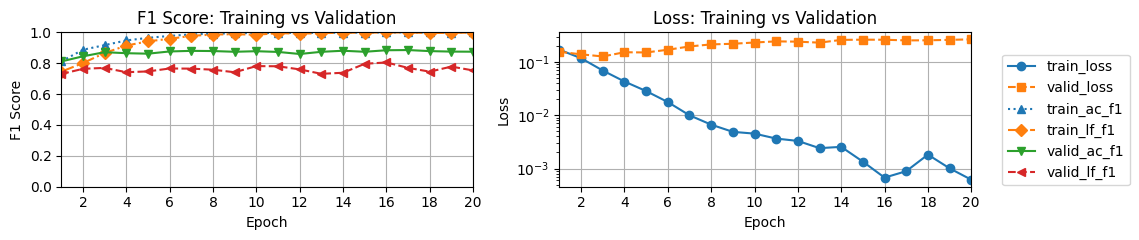

In [ ]:
output_dim = len(ner_tag_vocab)
pos_vocab_size = len(pos_tag_vocab)
pos_embedding_dim = 16

biobertpostags_model = BioBertPosTagsClassifier(output_dim, pos_vocab_size, pos_embedding_dim)
optimizer = torch.optim.Adam(biobertpostags_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

biobertpostags_model = biobertpostags_model.to(DEVICE)
criterion = criterion.to(DEVICE)

best_biobertpostags_model = train_model(biobertpostags_model,
                                        train_biobert_loader,
                                        val_biobert_loader,
                                        optimizer,
                                        criterion,
                                        ner_tag_to_ix,
                                        epochs=EPOCHS,
                                        is_bert_model=True)

### Save Best Model to Drive

In [ ]:
!zip -r models/biobert_postags_cased__e_16.pt.zip . -i models/biobert_postags_cased__e_16.pt
!cp models/biobert_postags_cased__e_16.pt.zip /content/drive/MyDrive/

  adding: models/biobert_postags_cased__e_16.pt (deflated 7%)


### Model Parameter Count

In [ ]:
print(f'The model has {count_parameters(biobertpostags_model):,} trainable parameters')

The model has 107,723,124 trainable parameters


### Model Evaluation

#### Metrics

Evaluation: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


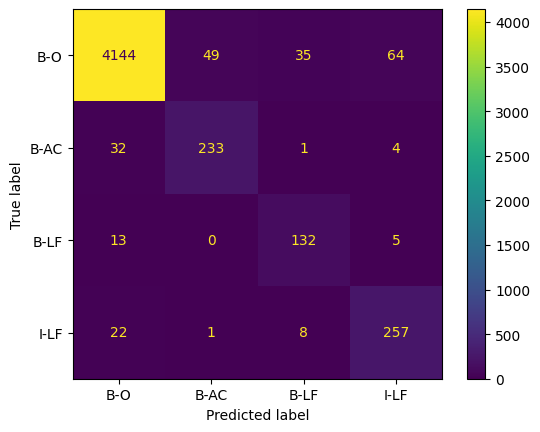

Loss: 0.29643169, Overall F1 Score: 0.95804047
Per-Entity metrics:
{'AC': {'f1': 0.8426763110307415,
        'number': 270,
        'precision': 0.823321554770318,
        'recall': 0.8629629629629629},
 'LF': {'f1': 0.7245508982035929,
        'number': 152,
        'precision': 0.6648351648351648,
        'recall': 0.7960526315789473},
 'O': {'f1': 0.9747148065388687,
       'number': 4292,
       'precision': 0.9840892899548801,
       'recall': 0.9655172413793104},
 'overall_accuracy': 0.9532,
 'overall_f1': 0.9580404685835995,
 'overall_precision': 0.9619332763045337,
 'overall_recall': 0.9541790411540093}


In [ ]:
test_avg_loss, test_metrics = evaluate(best_biobertpostags_model, test_biobert_loader, criterion, ner_tag_to_ix, is_bert_model=True, display_cm=True)

evaluate_metrics(test_metrics, test_avg_loss)

#### Inspect the output from a single batch

In [ ]:
biobert_fast_tokenizer = BertTokenizerFast.from_pretrained(check_point)
display_predictions(best_biobertpostags_model, biobert_fast_tokenizer, test_biobert_loader, test_biobert_dataset, is_bert_model=True, is_bert_tokenizer=True)

Example 1:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Tokens (post-tokenizer),A,:,GE,",",Global,En,Multi,Study,;,VIP,",",vent,improved,pit,.
Tokens (pre-tokenizer),Abbreviations,:,GEMS,",",Global,Enteric,Multicenter,Study,;,VIP,",",ventilated,improved,pit,.
True Labels,B-O,B-O,B-AC,B-O,B-LF,I-LF,I-LF,I-LF,B-O,B-AC,B-O,B-LF,I-LF,I-LF,B-O
Predicted Labels,B-O,B-O,B-AC,B-O,B-LF,I-LF,I-LF,I-LF,B-O,B-AC,B-O,B-LF,I-LF,I-LF,B-O




Example 2:


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
Tokens (post-tokenizer),Fr,from,F,pu,were,treated,with,La,buffer,[,...,to,activate,IL,in,the,lung,[,22,],.
Tokens (pre-tokenizer),Fractions,from,FPLC,purification,were,treated,with,Laemmli,buffer,[,...,to,activate,ILC2,in,the,lung,[,"22,24",],.
True Labels,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,...,B-O,B-O,B-AC,B-O,B-O,B-O,B-O,B-O,B-O,B-O
Predicted Labels,B-O,B-O,B-AC,B-O,B-O,B-O,B-O,B-O,B-O,B-O,...,B-O,B-O,B-AC,B-O,B-O,B-O,B-O,B-O,B-O,B-O




Example 3:


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
Tokens (post-tokenizer),We,developed,a,variant,of,gene,set,en,analysis,(,...,pathway,shows,evidence,for,age,regulation,[,23,],.
Tokens (pre-tokenizer),We,developed,a,variant,of,gene,set,enrichment,analysis,(,...,pathway,shows,evidence,for,age,regulation,[,23,],.
True Labels,B-O,B-O,B-O,B-O,B-O,B-LF,I-LF,I-LF,I-LF,B-O,...,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O
Predicted Labels,B-O,B-O,B-O,B-O,B-O,B-LF,I-LF,I-LF,I-LF,B-O,...,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O,B-O


## Group Assignment: Quantization of best model

### Download and unzip best model

In [ ]:
!gdown 1--lamen5vIhAk6oGWiwFhzJJSdWSyLTr

!unzip biobert_postags_cased__e_16.pt.zip

Downloading...
From (original): https://drive.google.com/uc?id=1--lamen5vIhAk6oGWiwFhzJJSdWSyLTr
From (redirected): https://drive.google.com/uc?id=1--lamen5vIhAk6oGWiwFhzJJSdWSyLTr&confirm=t&uuid=21461f01-90d4-4a01-9be4-e89ebe9f94b6
To: /content/biobert_postags_cased__e_16.pt.zip
100% 399M/399M [00:09<00:00, 43.7MB/s]
Archive:  biobert_postags_cased__e_16.pt.zip
  inflating: models/biobert_postags_cased__e_16.pt  


### Load Model

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.quantization import quantize_dynamic

class BioBertPosTagsClassifier(nn.Module):
  def __init__(self, output_dim, pos_vocab_size, pos_embedding_dim):
    super(BioBertPosTagsClassifier, self).__init__()
    self.model_label = 'biobert_postags_cased'
    self.bert = BertModel.from_pretrained('dmis-lab/biobert-v1.1',
                                          num_labels=output_dim,
                                          add_pooling_layer=False)

    # Add 1 to pos_vocab_size to account for the special -100 index.
    # We'll reserve the last embedding vector for -100 indices.
    self.pos_embedding = nn.Embedding(num_embeddings=pos_vocab_size + 1,
                                      embedding_dim=pos_embedding_dim,
                                      padding_idx=pos_vocab_size)

    # Adjust the input size of the classifier
    combined_embedding_dim = self.bert.config.hidden_size + pos_embedding_dim
    self.fc = nn.Linear(combined_embedding_dim, output_dim)

  def forward(self, text, attention_mask, pos_tags):
    outputs = self.bert(text, attention_mask=attention_mask, return_dict=False)

    sequence_output = outputs[0]  # [batch_size, sequence_length, 768]

    # Adjust pos_tags to ensure -100 indices map to the last embedding vector
    adjusted_pos_tags = torch.where(pos_tags == -100, torch.tensor(self.pos_embedding.padding_idx, device=pos_tags.device), pos_tags)

    # Get embeddings from POS tags
    pos_embeddings = self.pos_embedding(adjusted_pos_tags)

    # Concatenate BERT and POS embeddings
    combined_embeddings = torch.cat((sequence_output, pos_embeddings), dim=-1)

    logits = self.fc(combined_embeddings)

    return logits

output_dim = len(ner_tag_vocab)
pos_vocab_size = len(pos_tag_vocab)
pos_embedding_dim = 16

biobertpostags_model = BioBertPosTagsClassifier(output_dim, pos_vocab_size, pos_embedding_dim)
biobertpostags_model.load_state_dict(torch.load('models/biobert_postags_cased__e_16.pt', map_location=DEVICE))
biobertpostags_model = biobertpostags_model.to(DEVICE)

biobertpostags_model.eval()

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-v1.1 were not used when initializing BertModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BioBertPosTagsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

### Evaluate model Before

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

test_avg_loss, test_metrics = evaluate(biobertpostags_model, test_biobert_loader, criterion, ner_tag_to_ix, is_bert_model=True, display_cm=True)

evaluate_metrics(test_metrics, test_avg_loss)

Evaluation:   4%|▍         | 3/77 [00:28<11:47,  9.56s/it]


KeyboardInterrupt: 

### Apply Dynamic Quantisation

In [ ]:
# Apply dynamic quantization
biobertpostags_quantized = quantize_dynamic(
    biobertpostags_model,  # the original model
    {torch.nn.Linear},  # specify which type of layers to quantize
    dtype=torch.qint8  # the data type to convert the weights to
)

### Check model reduction

In [ ]:
!ls -lh /content/models/

total 748M
-rw-r--r-- 1 root root 412M Apr 19 22:14 biobert_postags_cased__e_16.pt
-rw-r--r-- 1 root root 169M May 23 15:44 quantized_biobert_postags_cased__e_16.pt
-rw-r--r-- 1 root root 169M May 23 15:39 quantized_biobert_postags_cased.pt


### Evaluate model after

Evaluation: 100%|██████████| 77/77 [04:43<00:00,  3.69s/it]


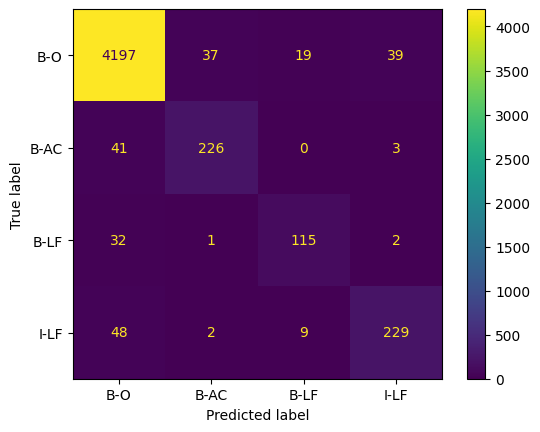

Loss: 0.16523563, Overall F1 Score: 0.95725772
Per-Entity metrics:
{'AC': {'f1': 0.8432835820895522,
        'number': 270,
        'precision': 0.849624060150376,
        'recall': 0.837037037037037},
 'LF': {'f1': 0.6601307189542484,
        'number': 152,
        'precision': 0.6558441558441559,
        'recall': 0.6644736842105263},
 'O': {'f1': 0.9749128919860626,
       'number': 4292,
       'precision': 0.9719777674849467,
       'recall': 0.977865796831314},
 'overall_accuracy': 0.9534,
 'overall_f1': 0.9572577232331781,
 'overall_precision': 0.9548332629801604,
 'overall_recall': 0.9596945269410267}


In [ ]:
test_avg_loss, test_metrics = evaluate(biobertpostags_quantized, test_biobert_loader, criterion, ner_tag_to_ix, is_bert_model=True, display_cm=True)

evaluate_metrics(test_metrics, test_avg_loss)

### Results comparison

In [ ]:
# Before quantisation
# Evaluation: 100%|██████████| 77/77 [05:23<00:00,  4.20s/it]
# F1: AC = 0.84, LF = 0.72
# Model size: 412MB

# After quantisation:
# Evaluation: 100%|██████████| 77/77 [04:09<00:00,  3.25s/it]
# F1: AC = 0.83, LF = 0.66
# Model size: 169MB

### Save Model

In [ ]:
!zip -r models/quantized_biobert_postags_cased__e_16.pt.zip . -i models/quantized_biobert_postags_cased__e_16.pt
!cp models/quantized_biobert_postags_cased__e_16.pt.zip /content/drive/MyDrive/

Scanning files 
  adding: models/quantized_biobert_postags_cased__e_16.pt (deflated 23%)
